In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import os
import requests
import zipfile
import gzip
import shutil
import glob
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
import torchvision.transforms as transforms
from torchvision import datasets
if torch.backends.mps.is_available():
    print("Using the MPS. You are good to go!")
    device = torch.device("mps")
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the MPS. You are good to go!


In [ ]:
device = 'cpu' # 3D conv cannot be run on MPS

In [ ]:
import pickle
database_tr = None
with open('./DataSet/database_tr2.pkl', 'rb') as f:
    database_tr = pickle.load(f)
print(len(database_tr))
database_val = None
with open('./DataSet/database_val2.pkl', 'rb') as f:
    database_val = pickle.load(f)
print(len(database_val))

32
32


In [ ]:
from scipy.ndimage import zoom, rotate
from scipy.ndimage import map_coordinates, gaussian_filter

class Rescale3D:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, image):
        # print(image.shape)
        D, H, W = image.shape
        new_D, new_H, new_W = self.output_size
        scale_D, scale_H, scale_W = new_D / D, new_H / H, new_W / W
        image = zoom(image, (scale_D, scale_H, scale_W), order=1)
        return image

class CenterCrop3D:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, image):
        # print(image.shape)
        D, H, W = image.shape
        new_D, new_H, new_W = self.output_size
        start_d = (D - new_D)//2
        start_h = (H - new_H)//2
        start_w = (W - new_W)//2
        image = image[start_d:start_d+new_D, start_h:start_h+new_H, start_w:start_w+new_W]
        return image


In [ ]:
class Tran3D:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for tr in self.transforms:
            image = tr(image)
        return image

transform = Tran3D([Rescale3D((155, 256, 256)), CenterCrop3D((144, 224, 224))])

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
class BraTDataset(torch.utils.data.Dataset):
        # refer to Medical Image Segmentation with Diffusion Model, 2020, https://github.com/KidsWithTokens/MedSegDif
    def __init__(self, database, transform, test_flag=False):
        super().__init__()
        self.transform = transform
        self.test_flag=test_flag
        self.database = database
        if test_flag:
            self.keys = ['t1', 't1ce', 't2', 'flair']
        else:
            self.keys = ['t1', 't1ce', 't2', 'flair', 'seg']

    def __len__(self):
        return len(self.database)

    def __getitem__(self, x):
        out = []
        n = x
        dict = self.database[n]
        for key in self.keys:
            img = dict[key]
            img = np.transpose(img, (2, 0, 1))
            if self.transform:
                img = self.transform(img)
            op = torch.tensor(img)
            out.append(op)
        out = torch.stack(out)

        if self.test_flag:
            image=out
            return (image, image)
        else:
            image = out[:-1, ...]
            label = out[-1, ...][None, ...]
            label=torch.where(label > 0, 1, 0).float()
            return (image, label)

ds_tr = BraTDataset(database=database_tr, transform=transform, test_flag=False)
ds_val = BraTDataset(database=database_val, transform=transform, test_flag=False)


torch.Size([1, 4, 144, 224, 224])
torch.Size([1, 1, 144, 224, 224])
torch.Size([1, 4, 144, 224, 224])
torch.Size([1, 1, 144, 224, 224])
torch.Size([1, 4, 144, 224, 224])
torch.Size([1, 1, 144, 224, 224])
torch.Size([1, 4, 144, 224, 224])
torch.Size([1, 1, 144, 224, 224])


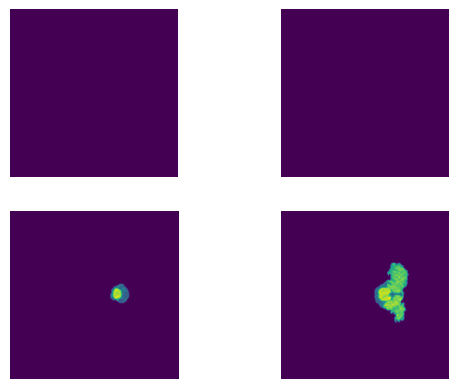

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(ds_tr, batch_size=1, shuffle=True)
val_loader = DataLoader(ds_val, batch_size=1, shuffle=True)


fig, axes = plt.subplots(2, 2)
axes = np.reshape(axes, (4, ))
for i in range(4):
  example = train_loader.__iter__().__next__()
  image = example[0]
  label = example[1]
  print(image.shape)
  print(label.shape)
  axes[i].imshow(image[0, 0, 0, :, :])
  axes[i].axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet3D, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.in1 = DoubleConv(n_channels, 8)
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 64)
        self.up1 = Up(64, 32)
        self.up2 = Up(32, 16)
        self.up3 = Up(16, 8)
        self.out = OutConv(8, n_classes)

    def forward(self, x):
        x1 = self.in1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.up1(x4, x3)
        x6 = self.up2(x5, x2)
        x7 = self.up3(x6, x1)
        logit = self.out(x7)
        return logit

# Example of using the network
if __name__ == '__main__':
    model = UNet3D(n_channels=4, n_classes=1).to(device)
    # print(model)
    x = torch.randn(1, 4, 144, 224, 224, device=device)  # Random input
    with torch.no_grad():
        output = model(x)
        print(output.size())

torch.Size([1, 1, 144, 224, 224])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-30):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, labels):
        logits_bound = torch.sigmoid(logits)

        label_flat = labels.view(-1)

        logits_flat = logits_bound .view(-1)

        intersection = (label_flat * logits_flat).sum()

        dice_score = (2. * intersection + 1e-30) / (label_flat.sum() + logits_flat.sum() + 1e-30)

        dice_loss = 1 - dice_score

        return dice_loss

In [ ]:
def evaluate(model, loader, loss_fun):
    model.eval()
    accuracy = 0
    count = 0
    with torch.no_grad():
        for batch, label in tqdm(loader):
            if len(np.unique(label)) == 1:
                continue
            batch = batch.to(device=device, dtype=torch.float)
            label = label.to(device=device, dtype=torch.float)
            pred = model(batch)
            count = count + 1
            score = 1 - loss_fun(pred, label)
            accuracy = accuracy + score
        Accuracy = accuracy / count
        print("\n Accuracy: {}".format(Accuracy))
        return Accuracy

In [ ]:
import torch.nn.init as init
model = UNet3D(n_channels=4, n_classes=1)
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.uniform(m.weight, 0, 1)
        if m.bias is not None:
            init.constant_(m.bias, 0)

model = model.to(device)

learning_rate, weight_decay, num_epoch = 0.05, 0, 30
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
# criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()

def train(model, trainloader, valloader, num_epoch=10):
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    evaluate(model, trainloader, criterion)
    print("Start training...")
    model.train()
    for i in range(num_epoch):
        running_loss = 0.0
        model.train()
        print('-----------------Epoch = %d-----------------' % (i+1))
        count = 0
        for batch, label in tqdm(trainloader):
            if len(np.unique(label)) == 1 and count % 2 == 0:
                continue
            batch = batch.to(device=device, dtype=torch.float)
            label = label.to(device=device, dtype=torch.float)
            # print(label.shape)
            optimizer.zero_grad()
            pred = model(batch)
            loss = criterion(pred, label)
            count = count + 1
            running_loss = running_loss + loss.item()
            loss.backward()
            optimizer.step()
        print("\n Epoch {} loss:{}".format(i+1, running_loss/count))
        torch.save(model.state_dict(), 'model_32dice3D_{}.pth'.format(i+1))
        trn_loss_hist.append(running_loss/count)
        print("\n Evaluate on training set...")
        trn_acc_hist.append(evaluate(model, trainloader, criterion))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader, criterion))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist

trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader,
                                                  val_loader, num_epoch)

100%|██████████| 32/32 [03:16<00:00,  6.14s/it]



 Accuracy: 0.04552162438631058
Start training...
-----------------Epoch = 1-----------------


100%|██████████| 32/32 [07:33<00:00, 14.16s/it]



 Epoch 1 loss:0.9552549999207258

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.04976237565279007

 Evaluate on validation set...


100%|██████████| 32/32 [03:16<00:00,  6.15s/it]



 Accuracy: 0.05005412548780441
-----------------Epoch = 2-----------------


100%|██████████| 32/32 [07:31<00:00, 14.10s/it]



 Epoch 2 loss:0.944525633007288

 Evaluate on training set...


100%|██████████| 32/32 [03:13<00:00,  6.05s/it]



 Accuracy: 0.054489776492118835

 Evaluate on validation set...


100%|██████████| 32/32 [03:15<00:00,  6.10s/it]



 Accuracy: 0.05479620769619942
-----------------Epoch = 3-----------------


100%|██████████| 32/32 [07:27<00:00, 13.99s/it]



 Epoch 3 loss:0.9409387949854136

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.05777285248041153

 Evaluate on validation set...


100%|██████████| 32/32 [03:15<00:00,  6.10s/it]



 Accuracy: 0.059636496007442474
-----------------Epoch = 4-----------------


100%|██████████| 32/32 [07:27<00:00, 13.99s/it]



 Epoch 4 loss:0.9379320871084929

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.059239745140075684

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]



 Accuracy: 0.060429658740758896
-----------------Epoch = 5-----------------


100%|██████████| 32/32 [07:25<00:00, 13.93s/it]



 Epoch 5 loss:0.934785533696413

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.062097784131765366

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]



 Accuracy: 0.06357693672180176
-----------------Epoch = 6-----------------


100%|██████████| 32/32 [07:26<00:00, 13.94s/it]



 Epoch 6 loss:0.9312018137425184

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.06471637636423111

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.0661960244178772
-----------------Epoch = 7-----------------


100%|██████████| 32/32 [07:26<00:00, 13.94s/it]



 Epoch 7 loss:0.9269564170390368

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.06851410865783691

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.07020852714776993
-----------------Epoch = 8-----------------


100%|██████████| 32/32 [07:25<00:00, 13.92s/it]



 Epoch 8 loss:0.9219333566725254

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.07481136918067932

 Evaluate on validation set...


100%|██████████| 32/32 [03:11<00:00,  6.00s/it]



 Accuracy: 0.07904665172100067
-----------------Epoch = 9-----------------


100%|██████████| 32/32 [07:25<00:00, 13.92s/it]



 Epoch 9 loss:0.915276825428009

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.07788519561290741

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.08032406121492386
-----------------Epoch = 10-----------------


100%|██████████| 32/32 [07:26<00:00, 13.94s/it]



 Epoch 10 loss:0.9067679084837437

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.08651657402515411

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.0900982916355133
-----------------Epoch = 11-----------------


100%|██████████| 32/32 [07:25<00:00, 13.94s/it]



 Epoch 11 loss:0.8951158560812473

 Evaluate on training set...


100%|██████████| 32/32 [03:11<00:00,  5.99s/it]



 Accuracy: 0.08812083303928375

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.08874619007110596
-----------------Epoch = 12-----------------


100%|██████████| 32/32 [07:25<00:00, 13.91s/it]



 Epoch 12 loss:0.8802796956151724

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.10202872008085251

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]



 Accuracy: 0.10448567569255829
-----------------Epoch = 13-----------------


100%|██████████| 32/32 [07:24<00:00, 13.91s/it]



 Epoch 13 loss:0.8618440143764019

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.11845225840806961

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.12177550792694092
-----------------Epoch = 14-----------------


100%|██████████| 32/32 [07:26<00:00, 13.96s/it]



 Epoch 14 loss:0.8325389344245195

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.14045898616313934

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]



 Accuracy: 0.15513582527637482
-----------------Epoch = 15-----------------


100%|██████████| 32/32 [07:26<00:00, 13.94s/it]



 Epoch 15 loss:0.8004545830190182

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.16405583918094635

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.17597158253192902
-----------------Epoch = 16-----------------


100%|██████████| 32/32 [07:26<00:00, 13.96s/it]



 Epoch 16 loss:0.7725951857864857

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.18538233637809753

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.2024814635515213
-----------------Epoch = 17-----------------


100%|██████████| 32/32 [07:26<00:00, 13.95s/it]



 Epoch 17 loss:0.738309420645237

 Evaluate on training set...


100%|██████████| 32/32 [03:11<00:00,  6.00s/it]



 Accuracy: 0.20966073870658875

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.19768591225147247
-----------------Epoch = 18-----------------


100%|██████████| 32/32 [07:25<00:00, 13.93s/it]



 Epoch 18 loss:0.5910346638411283

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.10148768872022629

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.11324066668748856
-----------------Epoch = 19-----------------


100%|██████████| 32/32 [07:25<00:00, 13.93s/it]



 Epoch 19 loss:0.5156161431223154

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.17627795040607452

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.1966148018836975
-----------------Epoch = 20-----------------


100%|██████████| 32/32 [07:26<00:00, 13.94s/it]



 Epoch 20 loss:0.41069385409355164

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.17009595036506653

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.19575180113315582
-----------------Epoch = 21-----------------


100%|██████████| 32/32 [07:27<00:00, 13.98s/it]



 Epoch 21 loss:0.35529202595353127

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.1260143220424652

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.15647996962070465
-----------------Epoch = 22-----------------


100%|██████████| 32/32 [07:26<00:00, 13.96s/it]



 Epoch 22 loss:0.31887886859476566

 Evaluate on training set...


100%|██████████| 32/32 [03:13<00:00,  6.03s/it]



 Accuracy: 0.364084392786026

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.01s/it]



 Accuracy: 0.36902523040771484
-----------------Epoch = 23-----------------


100%|██████████| 32/32 [07:26<00:00, 13.96s/it]



 Epoch 23 loss:0.32562587782740593

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.1857694536447525

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]



 Accuracy: 0.22621528804302216
-----------------Epoch = 24-----------------


100%|██████████| 32/32 [07:27<00:00, 13.97s/it]



 Epoch 24 loss:0.29383317194879055

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.406610906124115

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.4298567473888397
-----------------Epoch = 25-----------------


100%|██████████| 32/32 [07:30<00:00, 14.09s/it]



 Epoch 25 loss:0.2770303897559643

 Evaluate on training set...


100%|██████████| 32/32 [03:14<00:00,  6.09s/it]



 Accuracy: 0.23637576401233673

 Evaluate on validation set...


100%|██████████| 32/32 [03:14<00:00,  6.09s/it]



 Accuracy: 0.2575043737888336
-----------------Epoch = 26-----------------


100%|██████████| 32/32 [07:22<00:00, 13.82s/it]



 Epoch 26 loss:0.26007043942809105

 Evaluate on training set...


100%|██████████| 32/32 [03:11<00:00,  5.99s/it]



 Accuracy: 0.34039852023124695

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.00s/it]



 Accuracy: 0.3284262716770172
-----------------Epoch = 27-----------------


100%|██████████| 32/32 [07:19<00:00, 13.75s/it]



 Epoch 27 loss:0.27383231185376644

 Evaluate on training set...


100%|██████████| 32/32 [03:10<00:00,  5.94s/it]



 Accuracy: 0.3773423135280609

 Evaluate on validation set...


100%|██████████| 32/32 [03:09<00:00,  5.93s/it]



 Accuracy: 0.3734607696533203
-----------------Epoch = 28-----------------


100%|██████████| 32/32 [07:16<00:00, 13.65s/it]



 Epoch 28 loss:0.25081590563058853

 Evaluate on training set...


100%|██████████| 32/32 [03:11<00:00,  5.98s/it]



 Accuracy: 0.39385250210762024

 Evaluate on validation set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.3827929198741913
-----------------Epoch = 29-----------------


100%|██████████| 32/32 [07:25<00:00, 13.93s/it]



 Epoch 29 loss:0.2458495106548071

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.02s/it]



 Accuracy: 0.34586167335510254

 Evaluate on validation set...


100%|██████████| 32/32 [03:13<00:00,  6.04s/it]



 Accuracy: 0.32533639669418335
-----------------Epoch = 30-----------------


100%|██████████| 32/32 [07:25<00:00, 13.92s/it]



 Epoch 30 loss:0.2550047095865011

 Evaluate on training set...


100%|██████████| 32/32 [03:12<00:00,  6.03s/it]



 Accuracy: 0.4096086323261261

 Evaluate on validation set...


100%|██████████| 32/32 [03:18<00:00,  6.21s/it]


 Accuracy: 0.4512905776500702
Done!


In [ ]:
print(trn_loss_hist, trn_acc_hist, val_acc_hist)
with open ('model_32dice3D_round1.pkl', 'wb') as f:
    np.savez(f, trn_loss_hist=trn_loss_hist, trn_acc_hist=[a.cpu()  for a in trn_acc_hist], val_acc_hist=[a.cpu()  for a in val_acc_hist])

[0.9552549999207258, 0.944525633007288, 0.9409387949854136, 0.9379320871084929, 0.934785533696413, 0.9312018137425184, 0.9269564170390368, 0.9219333566725254, 0.915276825428009, 0.9067679084837437, 0.8951158560812473, 0.8802796956151724, 0.8618440143764019, 0.8325389344245195, 0.8004545830190182, 0.7725951857864857, 0.738309420645237, 0.5910346638411283, 0.5156161431223154, 0.41069385409355164, 0.35529202595353127, 0.31887886859476566, 0.32562587782740593, 0.29383317194879055, 0.2770303897559643, 0.26007043942809105, 0.27383231185376644, 0.25081590563058853, 0.2458495106548071, 0.2550047095865011] [tensor(0.0498), tensor(0.0545), tensor(0.0578), tensor(0.0592), tensor(0.0621), tensor(0.0647), tensor(0.0685), tensor(0.0748), tensor(0.0779), tensor(0.0865), tensor(0.0881), tensor(0.1020), tensor(0.1185), tensor(0.1405), tensor(0.1641), tensor(0.1854), tensor(0.2097), tensor(0.1015), tensor(0.1763), tensor(0.1701), tensor(0.1260), tensor(0.3641), tensor(0.1858), tensor(0.4066), tensor(0.2